<a href="https://colab.research.google.com/github/hmyrcmn/GAN/blob/main/CatImageCreating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# drive'a bağlanmak için doğrulama
# colab'a doğrudan upload edebiliriz, fakat kullanacağımız veriyi önceden
# drive'a yüklemek daha mantıklı, drive'dan daha hızlı yüklüyor ve bizim
# tarafımızda ek bir internet trafiği olmuyor, her session'da colab'daki
# disk alanı resetleniyor, yeniden yüklemek gerek.

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# kullanacağımız veriyi drive'ın ana klasöründe değil de belirli bir alt
# klasörde tutmak daha iyi, diğer türlü bağlantı hatası olabiliyor.
# tüm veri tek bir zip dosyası olursa daha kısa sürecektir, diğer türlü
# binlerce küçük dosyayı tek tek alması her dosya için ek işlem gerektirdiğinden
# süreyi uzatıyor.
# dosya drive'da şu adreste: /kerasders/kediler.zip

# orijinal veriyi şu adresten aldık: https://www.kaggle.com/crawford/cat-dataset
# içindeki klasörlerdeki resimleri CAT adlı bir klasörde toplayıp
# kediler.zip olarak arşivledim.

# zip_adres'de belirtilen drive'daki dosyayı colab'a kopyalamızı sağlıyor

zip_adres = "/content/drive/My Drive/kerasders/kediler.zip"
!cp "{zip_adres}" .

In [ ]:
# kediler.zip'i mevcut dizine çıkartır

!unzip -q kediler.zip

# zip'ten çıkarttığımız için zip dosyasını colab'dan silebiliriz,
# disk tasarufu için, çok dosya ile uğraşmayacaksak şart değil

!rm kediler.zip

In [ ]:
import os # dosyalara ulaşmak için kullanıyoruz
import cv2 # resimleri okumak ve işlemek için gerekli
from tqdm import tqdm # okuma işlemini takip için kullanıyoruz

# klasor_adresi'ndeki resimleri okurken boyut * boyut 
# şeklinde yeniden boyutlandıracağız, CNN için kare şeklinde olmaları avantaj
# kötü yanı: veride kareden çok farklı resimler orantısız olacak
# başta kareye benzemeyenleri elemek için ek işlem yapılabilir.
klasor_adresi = "CAT"
boyut = 64
kanal = 3 # RGB, üç renk için üç kanal

veri = []

for resim_adi in tqdm(os.listdir(klasor_adresi)):
    resim_adresi = os.path.join(klasor_adresi,resim_adi)
    resim = cv2.imread(resim_adresi, cv2.IMREAD_COLOR)
    if(resim is not None):
        resim = cv2.resize(resim,(boyut,boyut))
        veri.append([resim])

100%|██████████| 9993/9993 [01:21<00:00, 122.38it/s]


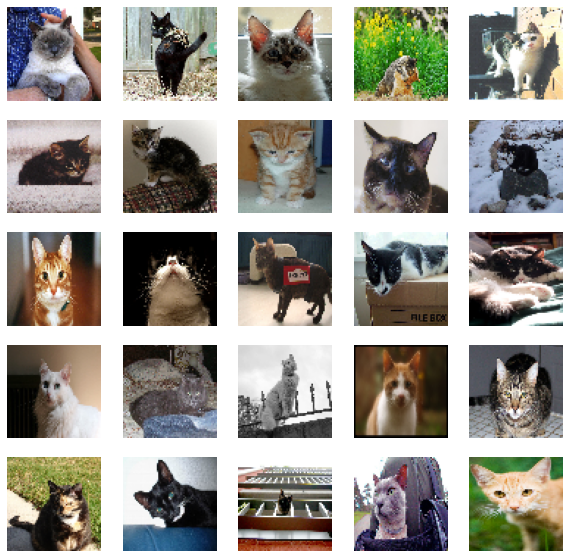

In [ ]:
# veri içindeki bazı örnekleri pyplot ile ekrana çiziyoruz

import matplotlib.pyplot as plt

# figür boyutunu elle ayarlamak için, sayılar inç türünden
fig = plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5, 5, i+1)

    # cv2 ile yüklenen resmin renk kanalları BGR şeklinde, ekrana çizerken RGB'ye dönüştürüyoruz.
    plt.imshow(cv2.cvtColor(veri[i][0], cv2.COLOR_BGR2RGB))
    plt.axis('off')

plt.show()

In [ ]:
import numpy

# veriyi numpy array'ine çevir, veri sayısı * boyut * boyut * 3 şeklinde
# renkli veri olduğu için 3 kanala sahip.
veri = numpy.array(veri).reshape(-1,boyut,boyut,kanal).astype('float32')

# piksel değerleri [0,255] aralığında, normalize edip [-1,1] aralığına çekiyoruz
# bu network için daha elverişli hale gelmelerini sağlıyor
veri = (veri - 127.5) / 127.5

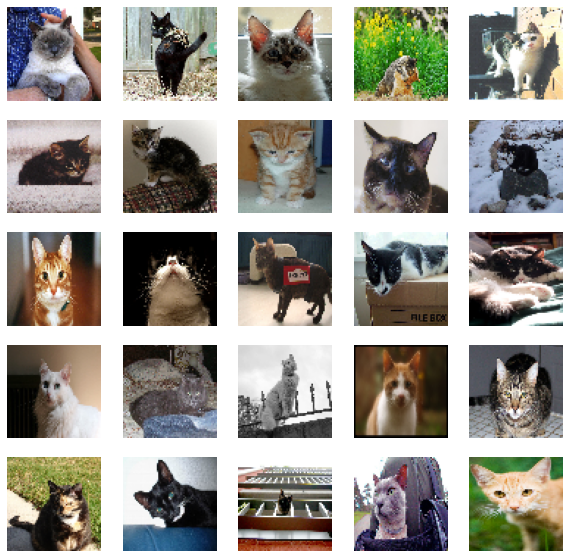

In [ ]:
# tekrar ekrana çizmek istersek piksel değerlerini tekrar [0,255]'e çekmeliyiz

fig = plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5, 5, i+1)

    # resim için 'uint8' türünde sayılar olmalı, o yüzden 'astype('uint8')' diyoruz.
    plt.imshow(cv2.cvtColor(((veri[i] * 127.5) + 127.5).astype('uint8'), cv2.COLOR_BGR2RGB))
    plt.axis('off')

plt.show()

In [ ]:
import tensorflow as tf

# veri'yi tensorflow tarafından kullanılabilecek hale getiriyoruz,
# BATCH_SIZE her seferinde kaç örneği network'e göndereceğimizi
# belirliyor. GPU memory'e sığacak en büyük sayıyı kullanabiliriz,
# 1 olursa her seferinde tek örneği kullanmış oluruz, GPU'nun
# paralel işleme gücünden faydalanmamış oluruz. Ek olarak batch
# normalization kullanıyorsak onu da etkileyen bir parametre.

BATCH_SIZE = 256
veri = tf.data.Dataset.from_tensor_slices(veri).batch(BATCH_SIZE)

In [ ]:
from tensorflow.keras import layers

# generator network noise'den resim oluşturmakla görevli,
# input noise boyutu fazla değil, aşama aşama boyutu arttırmamız gerekiyor.
# zamanla boyut arttırma işlemini input istediğimiz türden resimlere dönüşecek
# şekilde yapmasını öğrenecek.

NOISE_SIZE = 100 # bir resmi oluşturmak için kaç farklı değere ihtiyacımız olduğu, elle belirlediğimiz bir sayı

# GAN için iyi bir weight başlangıcı olarak öneriliyor
initializer = tf.random_normal_initializer(0., 0.02)

gen = tf.keras.Sequential()

gen.add(layers.Dense(4*4*512, use_bias=False, input_shape=(NOISE_SIZE,)))
gen.add(layers.BatchNormalization())
gen.add(layers.LeakyReLU())

gen.add(layers.Reshape((4, 4, 512)))

gen.add(layers.Conv2DTranspose(512, (3, 3), strides=(1, 1), padding='same', kernel_initializer=initializer, use_bias=False))
gen.add(layers.BatchNormalization())
gen.add(layers.LeakyReLU())

gen.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', kernel_initializer=initializer, use_bias=False))
gen.add(layers.BatchNormalization())
gen.add(layers.LeakyReLU())

gen.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer=initializer, use_bias=False))
gen.add(layers.BatchNormalization())
gen.add(layers.LeakyReLU())

gen.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', kernel_initializer=initializer, use_bias=False))
gen.add(layers.BatchNormalization())
gen.add(layers.LeakyReLU())

gen.add(layers.Conv2DTranspose(kanal, (5, 5), strides=(2, 2), padding='same', kernel_initializer=initializer, use_bias=False, activation='tanh'))

tf.Tensor(
[[-4.5950183e-01  2.3230276e-01  1.7770231e-01  6.9503099e-01
  -7.0332527e-01 -6.7204392e-01  1.5346879e+00 -1.5905467e-01
  -3.7268272e-01  2.1623483e+00  7.2963166e-01 -1.5411076e-01
   8.1472880e-01 -2.9458433e-01  1.5830570e-01 -5.6010622e-01
  -2.0818861e-01  1.6273671e+00 -1.7229205e+00  2.5816998e+00
  -1.0052016e+00  1.5066538e+00 -9.8312981e-02 -3.3023149e-01
   3.1635308e-01 -2.2269821e-01 -3.3693960e-01  3.4398856e-04
   4.6956137e-01 -6.4245641e-01 -8.5620576e-01  1.3992925e-01
   6.4704043e-01  9.2927915e-01  2.9302168e-01  1.8756929e-01
  -2.0406537e+00 -1.1289214e+00 -5.7968646e-01 -1.1378160e+00
  -5.9215486e-01 -7.0945293e-01 -2.1595533e-01 -6.2044519e-01
  -1.2632635e+00 -6.3348925e-01  2.0543346e+00 -5.7586300e-01
   1.2030144e+00  1.1296554e-01 -1.4826391e+00 -7.8278437e-02
  -2.1706793e+00 -6.5905595e-01  1.7881286e-01  1.0926312e-01
  -1.3290527e+00 -1.4313306e+00  2.1620593e+00  2.7582517e-01
  -3.2225695e-01  5.3461486e-01  1.5399656e+00  1.2853739e+

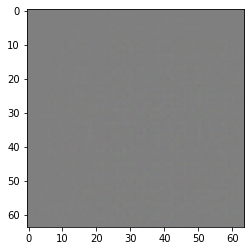

In [ ]:
# henüz eğitilmemiş gen'i test ediyoruz

noise = tf.random.normal([1, 100])
print(noise)

# gen'den output alıyoruz
test_resmi = gen(noise, training=False)

plt.imshow(cv2.cvtColor((test_resmi[0]* 127.5 + 127.5).numpy().reshape(boyut,boyut,kanal).astype('uint8') , cv2.COLOR_BGR2RGB))

In [ ]:
# discriminator gelen resmin gerçek veya sahte olduğunu ayırt etmekle görevli

dis = tf.keras.Sequential()

dis.add(layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', input_shape=[boyut, boyut, kanal], kernel_initializer=initializer, use_bias=False))
dis.add(layers.BatchNormalization())
dis.add(layers.LeakyReLU())
dis.add(layers.Dropout(0.2))

dis.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer=initializer, use_bias=False))
dis.add(layers.BatchNormalization())
dis.add(layers.LeakyReLU())
dis.add(layers.Dropout(0.2))

dis.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same', kernel_initializer=initializer, use_bias=False))
dis.add(layers.BatchNormalization())
dis.add(layers.LeakyReLU())
dis.add(layers.Dropout(0.2))

dis.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same', kernel_initializer=initializer, use_bias=False))
dis.add(layers.BatchNormalization())
dis.add(layers.LeakyReLU())
dis.add(layers.Dropout(0.2))

dis.add(layers.Flatten())

# son layer'da tek bir output veriyoruz,
# input resim gerçek mi yoksa sahte mi diye belirten bir sayı
dis.add(layers.Dense(1)) 

In [ ]:
# henüz eğitilmeden test_resmi için ne diyor diye bakmak için
print (dis(test_resmi))

tf.Tensor([[-0.00042302]], shape=(1, 1), dtype=float32)


In [ ]:
# network'ü eğitmek için hangi kombinasyonların iyi/kötü olduğunu
# belirtecek sayısal bir değere ihtiyacımız var.
# loss (kayıp) fonksiyonları bunu sağlıyor.
# kısaca true label (olması gereken değerler) ve predicted label (network'ün mevcut tahminleri)
# arasındaki farkın hesaplanma yöntemi.

# Keras'daki yardımcı loss fonksiyonları: https://www.tensorflow.org/api_docs/python/tf/keras/losses


# BinaryCrossentropy: sonuç iki class'dan birine ait olabilir (binary),
# iki olasılık arasındaki farkı hesaplar (true ve predicted)
# "from_logits=True" diyerek işlemi olasılık [0,1] değerleri üzerinden değil de
# bunların logaritması üzerinden yapacağımızı söylüyoruz.

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# discriminator için olan loss fonksiyonu, train ederken kullanılacak
# input olarak gerçek resimler (real) ve generator'ün oluşturduğu
# sahte resimler (fake) veriliyor.

def dis_loss(real_output, fake_output):
    # gerçek olanlar için output 1 olmalıydı
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    
    # sahte olanlar için de output 0 olmalıydı
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    # ikisinin toplamı discriminator'ın hatasını verecek,
    # yani gerçeğe gerçek, sahteye sahte demesi lazım, yoksa loss fazla olacak
    # bu loss miktarınca weight'ler backpropagation ile düzenlenecek.
    total_loss = real_loss + fake_loss
    return total_loss

# generator için loss daha sade, discriminator'un fake'ler için dediği 1 ise
# yani fake'e real dediyse, generator için iyi.
# discriminator fake'e fake diyorsa loss fazla olacak.

def gen_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# optimizer loss'a göre weight'leri hangi yönde ayarlamamız gerektiğini
# bulurken kullanılıyordu. çeşitli yöntemler var, şu an için CNN'lerde
# "adam" iyi bir başlangıç sunuyor, parametre olarak verdiğimiz learning rate
# tek turda weight'lerin ne kadar oranda değişebileceğini belirtiyor.

# iki network de farklı olduğundan iki optimizer gerekli.

gen_opt = tf.keras.optimizers.Adam(1e-4)
dis_opt = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# tek bir eğitim aşamasında yapacaklarımız
# "@tf.function" şeklinde belirmemiz bu kısmın tensorflow'da çalışacak şekilde compile edilmesini sağlıyor
@tf.function
def train_step(images):
    # BATCH_SIZE kadar noise vektörü oluştur, bu noise resmi oluşturmak için kullanılacak
    noise = tf.random.normal([BATCH_SIZE, NOISE_SIZE])

    # bu kısımda yaptığımız işlemler "with tf.GradientTape()" dediğimiz için
    # takip edilecek ve türevi alınabilir halde tutulacak
    # generator ve discriminator için iki ayrı GradientTape'e ihtiyacımız var
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        # bu batch için noise'den image yap
        generated_images = gen(noise, training=True)

        # real'i discriminator'dan geçir
        real_output = dis(images, training=True)

        # fake'i discriminator'dan geçir
        fake_output = dis(generated_images, training=True)

        # önceden yazdığımız fonksiyonlarla loss hesapla
        gen_loss_val = gen_loss(fake_output)
        dis_loss_val = dis_loss(real_output, fake_output)

    # generator ve discriminator'un eğitilebilen değişkenleri için türevleri hesapla
    grad_gen = gen_tape.gradient(gen_loss_val, gen.trainable_variables)
    grad_dis = dis_tape.gradient(dis_loss_val, dis.trainable_variables)

    # ve türevleri bu değişkenlere uygula
    gen_opt.apply_gradients(zip(grad_gen, gen.trainable_variables))
    dis_opt.apply_gradients(zip(grad_dis, dis.trainable_variables))

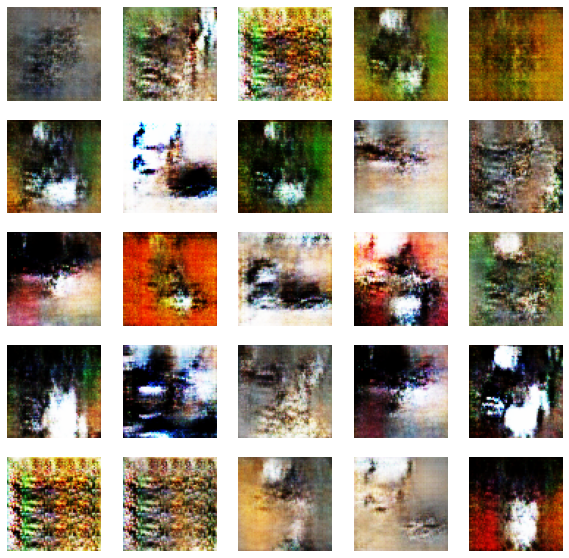

In [ ]:
from IPython import display # çıktıyı temizlemek için kullanacağız

EPOCHS = 5000 # eğitim sırasında tüm veri üzerinden kaç kez geçeceğimiz

# her epoch sonunda generator'ün halini kontrol ederken bu seed'i kullanacağız
seed = tf.random.normal([25, NOISE_SIZE]) # 25 tane farklı noise, 25 farklı image gösterebilmek için

# her epoch'da
for epoch in range(EPOCHS):
    
    # her batch için
    for image_batch in veri:
        # bir tur eğitim fonksiyonunu çağır
        train_step(image_batch)

    # bir epoch sonunda generator'ün ne durumda olduğunu kontrol etmek istiyoruz
    # aynı seed'i verip oluşturulan resimleri alıyoruz
    predictions = gen(seed, training=False)

    fig = plt.figure(figsize=(10,10))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(cv2.cvtColor((predictions[i]* 127.5 + 127.5).numpy().reshape(boyut,boyut,kanal).astype('uint8') , cv2.COLOR_BGR2RGB))
        plt.axis('off')

    plt.show()

    veri.shuffle(10000)

    # eski çizimi temizle
    display.clear_output(wait=True)

tf.Tensor([[-8.5729265]], shape=(1, 1), dtype=float32)


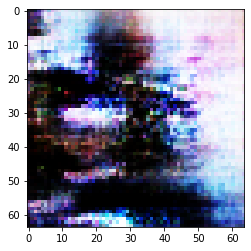

In [ ]:
# tekil bir test
noise = tf.random.normal([1, 100])
test_resmi = gen(noise, training=False)
plt.imshow(cv2.cvtColor((test_resmi[0]* 127.5 + 127.5).numpy().reshape(boyut,boyut,kanal).astype('uint8') , cv2.COLOR_BGR2RGB))
print (dis(test_resmi))

In [ ]:
gen_opt.learning_rate.assign(2e-5)
dis_opt.learning_rate.assign(2e-5)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=2e-06>